### Imports and Setup

In [1]:
import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, History
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

2024-06-25 15:55:10.732546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Function to extract numerical part from ID, used for Z1 and Z2_train
def extract_num_id(id):
    return re.findall(r'\d+', id)[0]

### Data

In [4]:
image_size = (224,224)

filelist_trainx_path = 'ISIC-2017/ISIC-2017_Training_Data'
filelist_trainx = sorted(glob.glob(filelist_trainx_path + '/*.jpg'), key=numericalSort)
filelist_length = len(filelist_trainx)

X_train = np.array([np.array(Image.open(fname).resize(image_size)) for fname in filelist_trainx
   ])

In [5]:
filelist_trainy_path = 'ISIC-2017/ISIC-2017_Training_Part1_GroundTruth'
filelist_trainy = sorted(glob.glob(filelist_trainy_path + '/*.png'), key=numericalSort)

Y_train = np.array([np.array(Image.open(fname).resize(image_size)) for fname in filelist_trainy])

In [33]:
Z1_train = pd.read_csv('ISIC-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
Z2_train = pd.read_csv('ISIC-2019/ISIC_2019_Training_Metadata.csv')

Z1_train['ID_number'] = Z1_train['image_id'].str.extract(r'(\d+)')
# Convert the extracted numbers to integer type
Z1_train['ID_number'] = Z1_train['ID_number'].astype(int)

Z2_train['ID_number'] = Z2_train['image'].str.extract(r'(\d+)')
Z2_train['ID_number'] = Z2_train['ID_number'].astype(int)

In [35]:
# Extract numerical IDs
Z1_train['NumID'] = Z1_train['image_id'].apply(extract_num_id)
Z2_train['NumID'] = Z2_train['image'].apply(extract_num_id)

# Find shared numerical IDs
shared_num_ids = set(Z1_train['NumID']).intersection(set(Z2_train['NumID']))

# Filter the DataFrames based on shared numerical IDs
df1_shared = Z1_train[Z1_train['NumID'].isin(shared_num_ids)]
df2_shared = Z2_train[Z2_train['NumID'].isin(shared_num_ids)]

# Merge the DataFrames to get combined information
Z_train_df = pd.merge(df1_shared, df2_shared, on='NumID', suffixes=('_df1', '_df2'))

# Drop the temporary NumID column
Z_train_df = Z_train_df.drop(columns=['NumID', 'image', 'age_approx', 'sex_df2', 'ID_number_df1', 'ID_number_df2'])
Z_train_df = Z_train_df.rename(columns={"sex_df1": "sex"})

pd.set_option("display.max_rows", None)
print(Z_train_df)


          image_id age_approximate      sex anatom_site_general     lesion_id
0     ISIC_0000000              55   female      anterior torso           NaN
1     ISIC_0000001              30   female      anterior torso           NaN
2     ISIC_0000002              60   female     upper extremity           NaN
3     ISIC_0000003              30     male     upper extremity           NaN
4     ISIC_0000004              80     male     posterior torso           NaN
5     ISIC_0000006              25   female     posterior torso           NaN
6     ISIC_0000007              25   female     posterior torso           NaN
7     ISIC_0000008              30   female      anterior torso           NaN
8     ISIC_0000009              30   female      anterior torso           NaN
9     ISIC_0000010              35   female     posterior torso           NaN
10    ISIC_0000011              35   female     lower extremity           NaN
11    ISIC_0000012              30     male     posterior torso 

In [36]:
unique = Z_train_df['anatom_site_general'].dropna()
unique.unique()



array(['anterior torso', 'upper extremity', 'posterior torso',
       'lower extremity', 'lateral torso', 'head/neck', 'palms/soles'],
      dtype=object)

In [40]:
Z_train_df_1h = pd.get_dummies(Z_train_df, columns=['sex', 'anatom_site_general'])
print(Z_train_df_1h)

          image_id age_approximate     lesion_id  sex_female  sex_male  \
0     ISIC_0000000              55           NaN        True     False   
1     ISIC_0000001              30           NaN        True     False   
2     ISIC_0000002              60           NaN        True     False   
3     ISIC_0000003              30           NaN       False      True   
4     ISIC_0000004              80           NaN       False      True   
5     ISIC_0000006              25           NaN        True     False   
6     ISIC_0000007              25           NaN        True     False   
7     ISIC_0000008              30           NaN        True     False   
8     ISIC_0000009              30           NaN        True     False   
9     ISIC_0000010              35           NaN        True     False   
10    ISIC_0000011              35           NaN        True     False   
11    ISIC_0000012              30           NaN       False      True   
12    ISIC_0000013              30    

In [6]:
print(X_train.shape)
print(Y_train.shape)

(2000, 224, 224, 3)
(2000, 224, 224)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)
print(x_train.shape)
print(y_train.shape)

(1500, 224, 224, 3)
(1500, 224, 224)


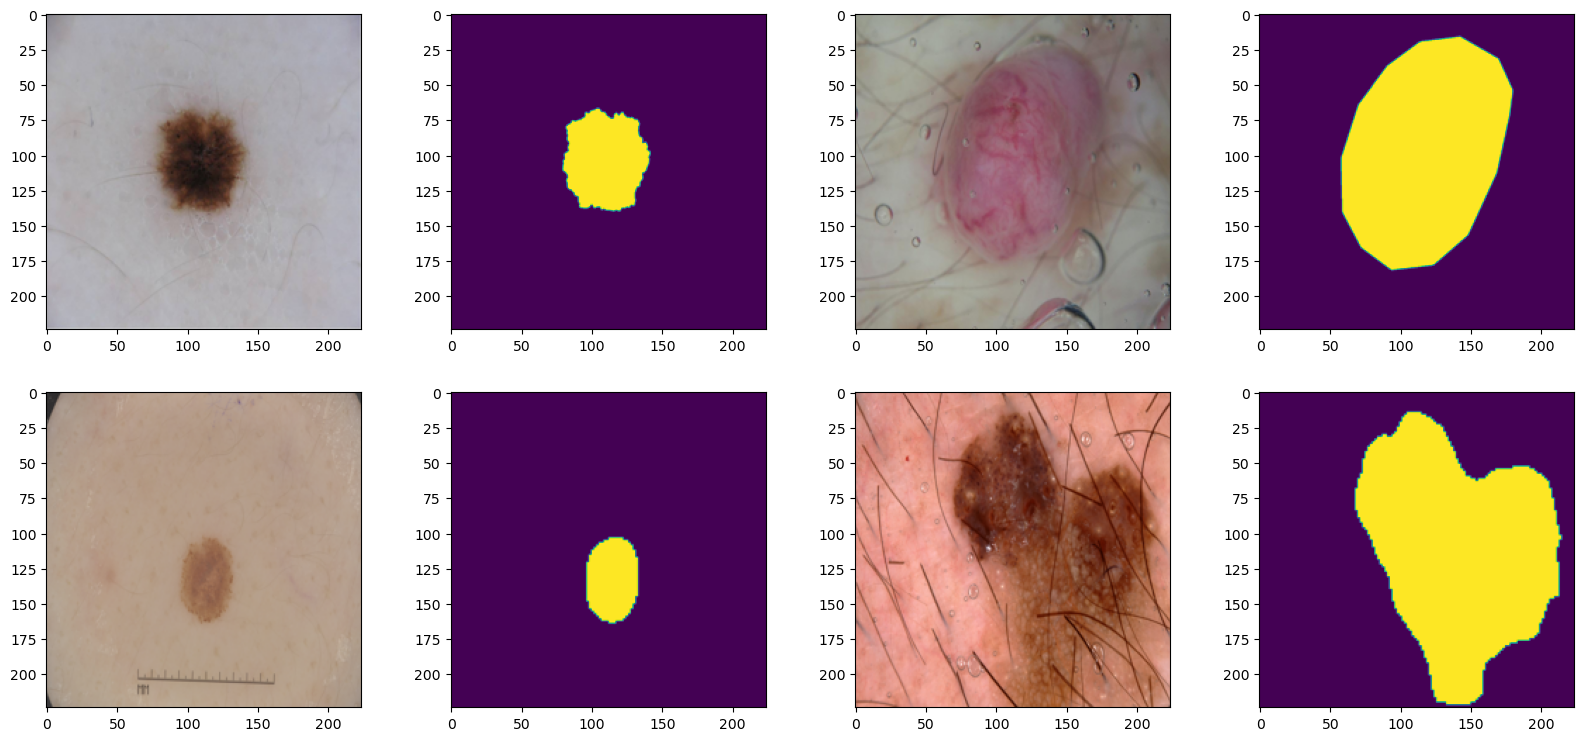

In [8]:
plt.figure(figsize=(20,9))

plt.subplot(2,4,1)
plt.imshow(X_train[1])
plt.subplot(2,4,2)
plt.imshow(Y_train[1])
plt.subplot(2,4,3)
plt.imshow(X_train[681])
plt.subplot(2,4,4)
plt.imshow(Y_train[681])
plt.subplot(2,4,5)
plt.imshow(X_train[1095])
plt.subplot(2,4,6)
plt.imshow(Y_train[1095])
plt.subplot(2,4,7)
plt.imshow(X_train[1978])
plt.subplot(2,4,8)
plt.imshow(Y_train[1978])
plt.show()

### Functions

In [9]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [10]:
#Image Augmentation
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [11]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

In [12]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 3600
Length of the Test Set       : 500
Length of the Validation Set : 900


## Model

In [14]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [15]:
checkpoint = ModelCheckpoint(
    'best_model_weights.h5',  # Path where the model weights will be saved
    monitor='val_loss',      
    save_best_only=True,     
    mode='min',               # Mode 'min' to save the model with the minimum `val_loss`
    verbose=1             
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [16]:
# Custom callback to save weights at specific epochs
class CustomModelCheckpoint(Callback):
    def __init__(self, save_epochs, filepath_template):
        super(CustomModelCheckpoint, self).__init__()
        self.save_epochs = save_epochs
        self.filepath_template = filepath_template

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_epochs:
            filepath = self.filepath_template.format(epoch=epoch + 1)
            self.model.save_weights(filepath)
            print(f"\nEpoch {epoch + 1}: saving model to {filepath}")

# Define the specific epochs at which to save the weights
save_epochs = [50, 100, 150, 200]
# Define the file path template for saving weights
filepath_template = 'model_weights_epoch_{epoch:03d}.h5'

# Instantiate the custom callback
increment_checkpoints = CustomModelCheckpoint(save_epochs, filepath_template)

In [17]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename, load_weights):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)

    model = Model(inputs, pred, name="UNET_224")

    if load_weights == True:
        model.load_weights('best_model_weights.h5')
        
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    # hist = model.fit(x_train, y_train, epochs=1, batch_size= 1,validation_data=(x_val, y_val), verbose=1)
    hist = model.fit(x_train, y_train, 
                     epochs=epochs_num, 
                     batch_size= 32,
                     validation_data=(x_val, y_val), 
                     verbose=1,
                     callbacks=[checkpoint, 
                                # increment_checkpoints, 
                                # early_stopping
                                ])
    model.save(savename)
    return model,hist

In [18]:
model, hist = UNET_224(50, 'unet_20_epoch.h5', True)


2024-06-25 16:02:10.891810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 16:02:10.892252: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-25 16:02:11.122633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 16:02:11.126153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
202

Model: "UNET_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

2024-06-25 16:02:14.021177: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1445068800 exceeds 10% of free system memory.
2024-06-25 16:02:14.773382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-25 16:02:14.801778: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/50


2024-06-25 16:02:17.345516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-06-25 16:02:19.442804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


113/113 [==============================] - 38s 281ms/step - loss: 0.5831 - iou: 0.4169 - dice_coe: 0.8260 - precision: 2.5132 - recall: 0.9945 - accuracy: 0.7264 - val_loss: 0.8218 - val_iou: 0.1782 - val_dice_coe: 1.9178 - val_precision: 0.2066 - val_recall: 0.9999 - val_accuracy: 0.0561

Epoch 00001: val_loss improved from inf to 0.82184, saving model to best_model_weights.h5
Epoch 2/50
113/113 [==============================] - 30s 261ms/step - loss: 0.5257 - iou: 0.4743 - dice_coe: 0.4032 - precision: 4.5122 - recall: 0.9428 - accuracy: 0.7850 - val_loss: 0.5184 - val_iou: 0.4816 - val_dice_coe: 0.7643 - val_precision: 1.4211 - val_recall: 0.9875 - val_accuracy: 0.7355

Epoch 00002: val_loss improved from 0.82184 to 0.51841, saving model to best_model_weights.h5
Epoch 3/50
113/113 [==============================] - 30s 261ms/step - loss: 0.5322 - iou: 0.4678 - dice_coe: 0.2669 - precision: 6.0470 - recall: 0.8414 - accuracy: 0.7857 - val_loss: 0.5156 - val_iou: 0.4844 - val_dice_co

### Predictions

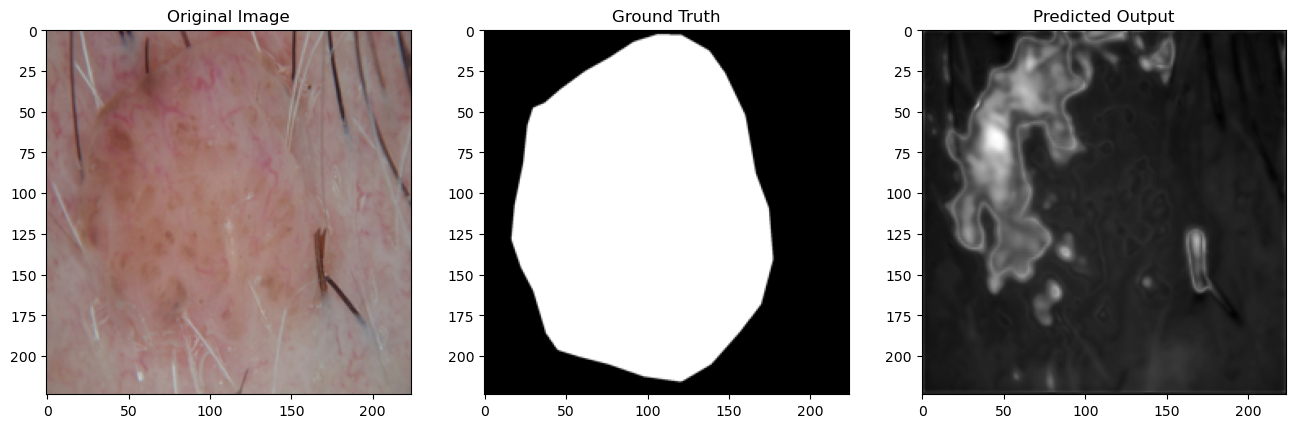

In [33]:
# Prediction for a single image
img_num = 104
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

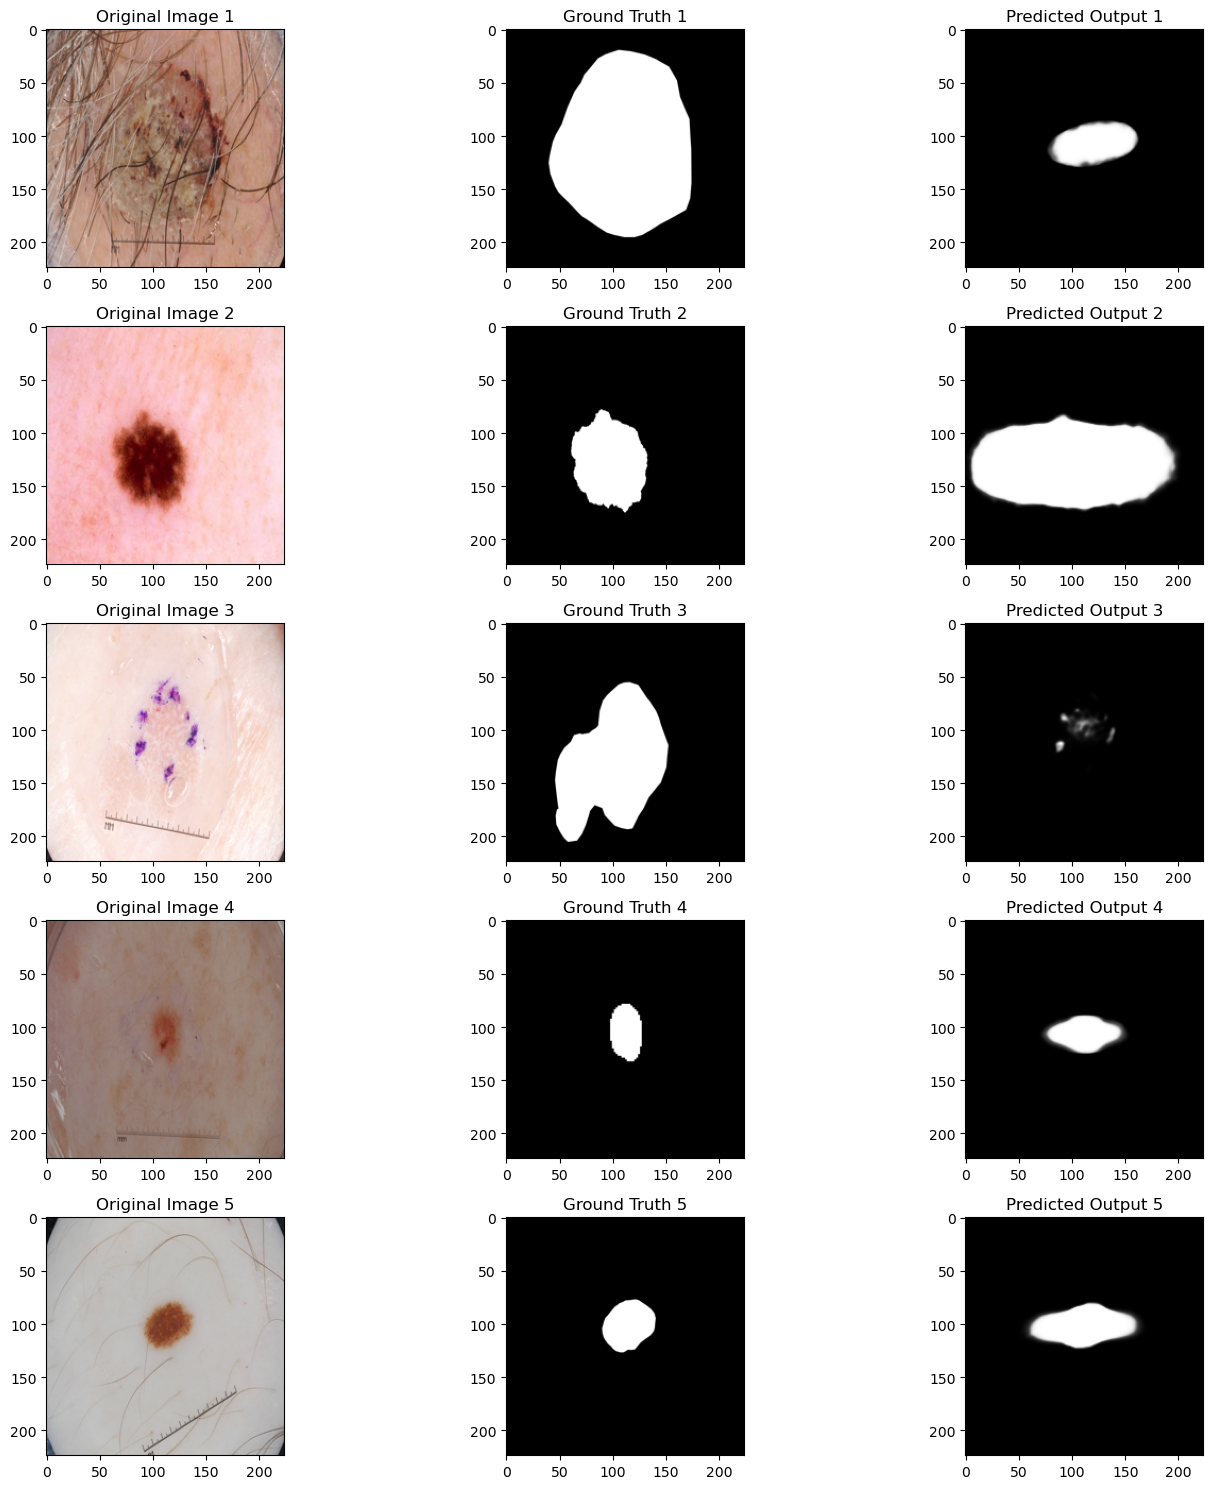

In [19]:
#Prediction for a batch of images
import matplotlib.pyplot as plt

# Assuming x_batch is your batch of images
predictions = model.predict(x_test)

# Visualize the results for the first few images in the batch
num_images_to_visualize = min(len(x_test), 5)

plt.figure(figsize=(15, 3 * num_images_to_visualize))

for i in range(num_images_to_visualize):
    plt.subplot(num_images_to_visualize, 3, 3 * i + 1)
    plt.imshow(x_test[i])
    plt.title(f'Original Image {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 2)
    plt.imshow(y_test[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Ground Truth {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
    plt.imshow(predictions[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Predicted Output {i + 1}')

# Optionally, you can add the ground truth for comparison
# Assuming y_batch is your batch of ground truth masks
if 'y_batch' in locals():
    for i in range(num_images_to_visualize):
        plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
        plt.imshow(y_test[i], plt.cm.binary_r)
        plt.title(f'Ground Truth {i + 1}')

plt.tight_layout()
plt.show()


In [ ]:
# like the previous, but can do for all epochs
#Prediction for a batch of images
import matplotlib.pyplot as plt

# Assuming x_batch is your batch of images
predictions = model.predict(x_test)

# Visualize the results for the first few images in the batch
num_images_to_visualize = min(len(x_test), 5)

plt.figure(figsize=(15, 3 * num_images_to_visualize))

for i in range(num_images_to_visualize):
    plt.subplot(num_images_to_visualize, 3, 3 * i + 1)
    plt.imshow(x_test[i])
    plt.title(f'Original Image {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 2)
    plt.imshow(y_test[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Ground Truth {i + 1}')

    plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
    plt.imshow(predictions[i].reshape(224, 224), plt.cm.binary_r)
    plt.title(f'Predicted Output {i + 1}')

# Optionally, you can add the ground truth for comparison
# Assuming y_batch is your batch of ground truth masks
if 'y_batch' in locals():
    for i in range(num_images_to_visualize):
        plt.subplot(num_images_to_visualize, 3, 3 * i + 3)
        plt.imshow(y_test[i], plt.cm.binary_r)
        plt.title(f'Ground Truth {i + 1}')

plt.tight_layout()
plt.show()


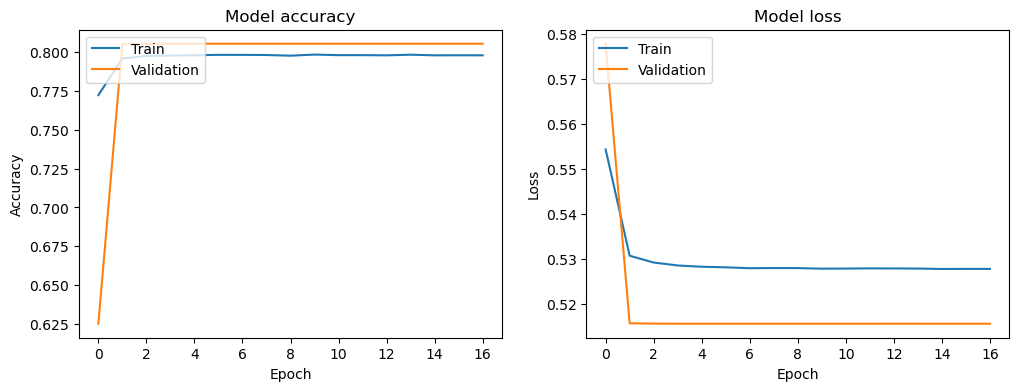

In [36]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.show()

In [29]:
hist.history.keys()

dict_keys(['loss', 'iou', 'dice_coe', 'precision', 'recall', 'accuracy', 'val_loss', 'val_iou', 'val_dice_coe', 'val_precision', 'val_recall', 'val_accuracy'])

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2024-06-25 15:55:22.121268: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-25 15:55:22.123858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-25 15:55:22.174232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 15:55:22.174434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2024-06-25 15:55:22.174510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
20

In [25]:
hist